In [6]:
# Import some libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import nest_asyncio
nest_asyncio.apply()
import datetime as dt
import re
import string
import io, json
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
# Load data from a CSV file into pandas DataFrame

tweets_data = pd.read_csv('dataset.csv')
tweets = tweets_data[['id', 'username', 'created_at', 'tweet']]
tweets

,id,username,created_at,tweet
0,1.330000e+18,njmyg_,2020-11-18 23:17:14 SE Asia Standard Time,@sunnova1324 @tanyainrl iya sih.. tapi maksud ...
1,1.330000e+18,urbbyyyyyyyy,2020-11-18 23:07:06 SE Asia Standard Time,males kuliah online temennya sikit
2,1.330000e+18,risyaanggun,2020-11-18 23:05:21 SE Asia Standard Time,tumbenan td kuliah online dosennya minta join ...
3,1.330000e+18,nyctophilexxx,2020-11-18 22:58:58 SE Asia Standard Time,@monsouleil nangis krn kecapean kuliah online ...
4,1.330000e+18,anisanwl,2020-11-18 22:50:53 SE Asia Standard Time,Apa hanya aku yang merasa semenjak kuliah onli...
...,...,...,...,...
24995,1.300000e+18,silverlines17,2020-08-23 23:46:32 SE Asia Standard Time,"@subtanyarl Iya, maka dari itu aku juga lebih ..."
24996,1.300000e+18,goblinahayy,2020-08-23 23:33:49 SE Asia Standard Time,"Ngulang maktul dimasa begini, ga lucu bgt sih ..."
24997,1.300000e+18,lolipiaa,2020-08-23 23:27:47 SE Asia Standard Time,"@collegemenfess Ngga kudu si, tp ya biar ga ri..."
24998,1.300000e+18,awanbiruuuu_,2020-08-23 23:27:37 SE Asia Standard Time,'semangat kuliah online nyaa' urusan paham ng...


In [8]:
# Some functions for preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

tweets['text_clean'] = tweets['tweet'].apply(cleaningText)

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

tweets['text_clean'] = tweets['text_clean'].apply(casefoldingText)

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    return text

tweets['text_preprocessed'] = tweets['text_clean'].apply(tokenizingText)

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered 
    return text

tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(filteringText)

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [9]:
# tweets['text_preprocessed'] = tweets['text_preprocessed'].apply(stemmingText)

# # drop duplicates/spams tweets
# tweets.drop_duplicates(subset = 'text_clean', inplace = True)

# # Export to csv file
tweets.to_csv(r'dataset_clean.csv', index = False, header = True, index_label=None)
tweets

,id,username,created_at,tweet,text_clean,text_preprocessed
0,1.330000e+18,njmyg_,2020-11-18 23:17:14 SE Asia Standard Time,@sunnova1324 @tanyainrl iya sih.. tapi maksud ...,iya sih tapi maksud sender kuliah online kali,"[iya, sih, maksud, sender, kuliah, online, kali]"
1,1.330000e+18,urbbyyyyyyyy,2020-11-18 23:07:06 SE Asia Standard Time,males kuliah online temennya sikit,males kuliah online temennya sikit,"[males, kuliah, online, temennya, sikit]"
2,1.330000e+18,risyaanggun,2020-11-18 23:05:21 SE Asia Standard Time,tumbenan td kuliah online dosennya minta join ...,tumbenan td kuliah online dosennya minta join ...,"[tumbenan, td, kuliah, online, dosennya, join,..."
3,1.330000e+18,nyctophilexxx,2020-11-18 22:58:58 SE Asia Standard Time,@monsouleil nangis krn kecapean kuliah online ...,nangis krn kecapean kuliah online,"[nangis, krn, kecapean, kuliah, online]"
4,1.330000e+18,anisanwl,2020-11-18 22:50:53 SE Asia Standard Time,Apa hanya aku yang merasa semenjak kuliah onli...,apa hanya aku yang merasa semenjak kuliah onli...,"[semenjak, kuliah, online, kinerja, otakku, me..."
...,...,...,...,...,...,...
24995,1.300000e+18,silverlines17,2020-08-23 23:46:32 SE Asia Standard Time,"@subtanyarl Iya, maka dari itu aku juga lebih ...",iya maka dari itu aku juga lebih seneng kuliah...,"[iya, seneng, kuliah, online]"
24996,1.300000e+18,goblinahayy,2020-08-23 23:33:49 SE Asia Standard Time,"Ngulang maktul dimasa begini, ga lucu bgt sih ...",ngulang maktul dimasa begini ga lucu bgt sih g...,"[ngulang, maktul, dimasa, ga, lucu, bgt, sih, ..."
24997,1.300000e+18,lolipiaa,2020-08-23 23:27:47 SE Asia Standard Time,"@collegemenfess Ngga kudu si, tp ya biar ga ri...",ngga kudu si tp ya biar ga ribet aja gt apalag...,"[ngga, kudu, si, tp, ya, biar, ga, ribet, aja,..."
24998,1.300000e+18,awanbiruuuu_,2020-08-23 23:27:37 SE Asia Standard Time,'semangat kuliah online nyaa' urusan paham ng...,semangat kuliah online nyaa urusan paham ngga...,"[semangat, kuliah, online, nyaa, urusan, paham..."


In [10]:
# Because preprocessing tweets data takes a lot time, so I load tweets data which has been preprocessed before
tweets = pd.read_csv('dataset_clean.csv')

for i, text in enumerate(tweets['text_preprocessed']):
    tweets['text_preprocessed'][i] = tweets['text_preprocessed'][i].replace("'", "")\
                                            .replace(',','').replace(']','').replace('[','')
    list_words=[]
    for word in tweets['text_preprocessed'][i].split():
        list_words.append(word)
        
    tweets['text_preprocessed'][i] = list_words   

## Determine Sentiment of Tweets with Indonesia Sentiment Lexicon

In [11]:
# Determine sentiment of tweets using indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

# Loads lexicon positive and negative data
lexicon_positive = dict()
import csv
with open('lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
        
# Function to determine sentiment sentiment of tweets        
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    sentiment=''
    if (score > 0):
        sentiment = 'positive'
    elif (score < 0):
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return score, sentiment

In [12]:
# Results from determine sentiment sentiment of tweets

results = tweets['text_preprocessed'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
tweets['sentiment_score'] = results[0]
tweets['sentiment'] = results[1]
print(tweets['sentiment'].value_counts())

# Export to csv file
tweets.to_csv(r'dataset_clean_sentiment.csv', index = False, header = True,index_label=None)
tweets

negative    12778
positive     8366
neutral      3856
Name: sentiment, dtype: int64


,id,username,created_at,tweet,text_clean,text_preprocessed,sentiment_score,sentiment
0,1.330000e+18,njmyg_,2020-11-18 23:17:14 SE Asia Standard Time,@sunnova1324 @tanyainrl iya sih.. tapi maksud ...,iya sih tapi maksud sender kuliah online kali,"[iya, sih, maksud, sender, kuliah, online, kali]",2,positive
1,1.330000e+18,urbbyyyyyyyy,2020-11-18 23:07:06 SE Asia Standard Time,males kuliah online temennya sikit,males kuliah online temennya sikit,"[males, kuliah, online, temennya, sikit]",-6,negative
2,1.330000e+18,risyaanggun,2020-11-18 23:05:21 SE Asia Standard Time,tumbenan td kuliah online dosennya minta join ...,tumbenan td kuliah online dosennya minta join ...,"[tumbenan, td, kuliah, online, dosennya, join,...",-1,negative
3,1.330000e+18,nyctophilexxx,2020-11-18 22:58:58 SE Asia Standard Time,@monsouleil nangis krn kecapean kuliah online ...,nangis krn kecapean kuliah online,"[nangis, krn, kecapean, kuliah, online]",-5,negative
4,1.330000e+18,anisanwl,2020-11-18 22:50:53 SE Asia Standard Time,Apa hanya aku yang merasa semenjak kuliah onli...,apa hanya aku yang merasa semenjak kuliah onli...,"[semenjak, kuliah, online, kinerja, otakku, me...",-3,negative
...,...,...,...,...,...,...,...,...
24995,1.300000e+18,silverlines17,2020-08-23 23:46:32 SE Asia Standard Time,"@subtanyarl Iya, maka dari itu aku juga lebih ...",iya maka dari itu aku juga lebih seneng kuliah...,"[iya, seneng, kuliah, online]",4,positive
24996,1.300000e+18,goblinahayy,2020-08-23 23:33:49 SE Asia Standard Time,"Ngulang maktul dimasa begini, ga lucu bgt sih ...",ngulang maktul dimasa begini ga lucu bgt sih g...,"[ngulang, maktul, dimasa, ga, lucu, bgt, sih, ...",-8,negative
24997,1.300000e+18,lolipiaa,2020-08-23 23:27:47 SE Asia Standard Time,"@collegemenfess Ngga kudu si, tp ya biar ga ri...",ngga kudu si tp ya biar ga ribet aja gt apalag...,"[ngga, kudu, si, tp, ya, biar, ga, ribet, aja,...",-5,negative
24998,1.300000e+18,awanbiruuuu_,2020-08-23 23:27:37 SE Asia Standard Time,'semangat kuliah online nyaa' urusan paham ng...,semangat kuliah online nyaa urusan paham ngga...,"[semangat, kuliah, online, nyaa, urusan, paham...",4,positive


## Analysis and Visualization

## Comparison Sentiment Sentiment on Tweets Data

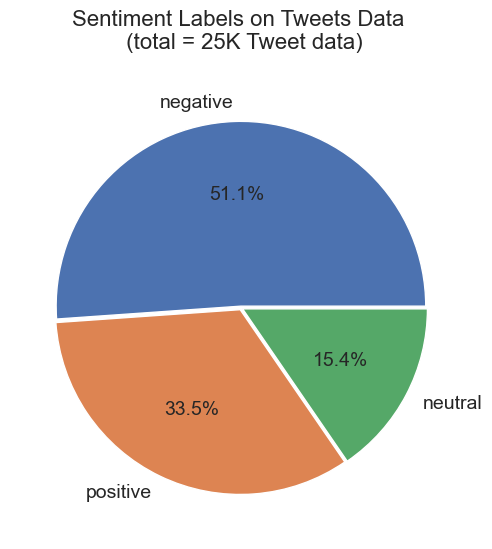

In [13]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in tweets['sentiment'].value_counts()]
labels = list(tweets['sentiment'].value_counts().index)
explode = (0.01, 0.01, 0.01)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Labels on Tweets Data \n (total = 25K Tweet data)', fontsize = 16, pad = 20)
plt.show()

## Word Cloud

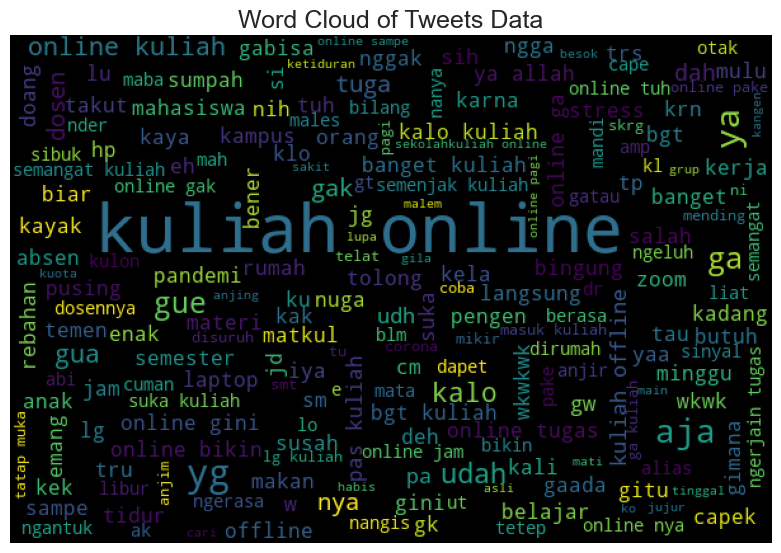

In [14]:
# Visualize word cloud

list_words=''
for tweet in tweets['text_preprocessed']:
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, background_color = 'black', min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## Positive and Negative Word Cloud

In [15]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]
        
        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)
            
    return positive_words, negative_words

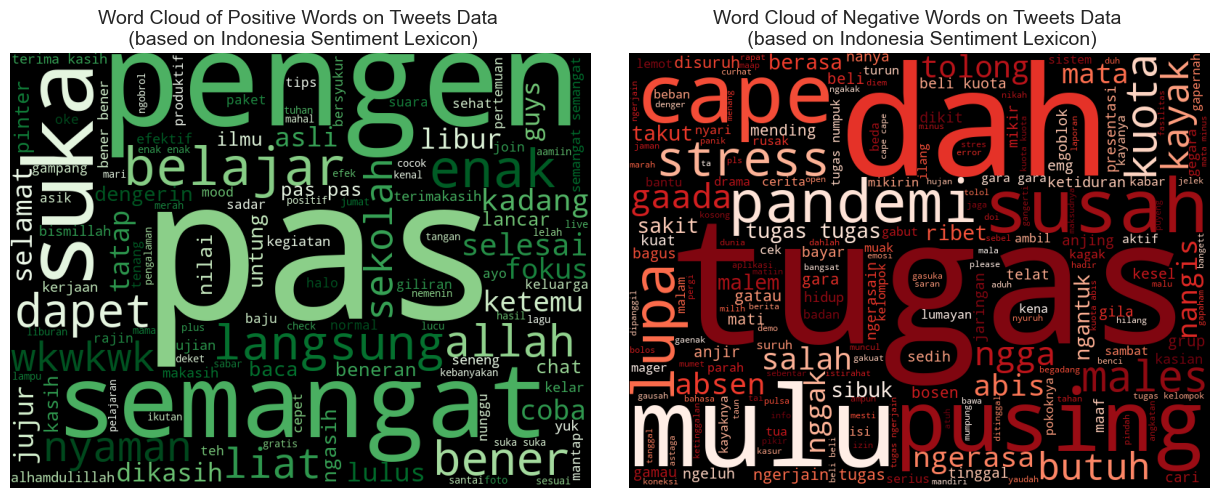

In [16]:
# Visualize positive and negative word cloud

sentiment_words = tweets['text_preprocessed'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                            , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                            , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')

plt.show()

# Sentiment Analysis Using LSTM

## Preprocessing Text Data

In [17]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function

X = tweets['text_preprocessed'].apply(toSentence) 
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X)
X.shape

(25000, 47)

In [18]:
# Encode target data into numerical values
sentiment_encode = {'negative' : 0, 'neutral' : 1, 'positive' : 2}
y = tweets['sentiment'].map(sentiment_encode).values

# Split the data (with composition data train 80%, data test 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20000, 47) (20000,)
(5000, 47) (5000,)


## Model LSTM

In [19]:
# Create model function with default hyperparameter values

# def create_model(embed_dim = 32, hidden_unit = 16, dropout_rate = 0.2, optimizers = RMSprop, learning_rate = 0.001):
#     model = Sequential()
#     model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X_train.shape[1]))
#     model.add(LSTM(units = hidden_unit, activation = 'tanh'))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(units = 3, activation = 'softmax'))
#     model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
#     print(model.summary())
#     return model

In [20]:
# Hyperparameter tuning (to know the best hyperparameter for this model)

# # Wrapper model with default hyperparameter values
# model = KerasClassifier(build_fn = create_model, epochs = 25, batch_size=128) 

# # Hyperparameters
# embed_dim = [32, 64]
# hidden_unit = [16, 32, 64]
# dropout_rate = [0.2]
# optimizers = [Adam, RMSprop]
# learning_rate = [0.01, 0.001, 0.0001]
# epochs = [10, 25, 50, 100]
# batch_size = [128, 256]
# param_grid = dict(embed_dim = embed_dim, hidden_unit = hidden_unit, dropout_rate = dropout_rate,
#                 learning_rate = learning_rate, optimizers = optimizers, epochs = epochs, batch_size = batch_size)

# # Evaluation model with GridSearchCV to know what the best hyperparameter for model 
# grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3)
# grid_result = grid.fit(X_train, y_train)

# results = pd.DataFrame()
# results['means'] = grid_result.cv_results_['mean_test_score']
# results['stds'] = grid_result.cv_results_['std_test_score']
# results['params'] = grid_result.cv_results_['params']
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# results.to_csv(r'gridsearchcv_result.csv', index = False, header = True)
# results.sort_values(by='means', ascending = False).reset_index(drop=True)

In [32]:
model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim = 64, input_length = X_train.shape[1]))
# model.add(embedding_layer)
model.add(LSTM(units =16, activation = 'tanh'))
model.add(Dropout(0.1))
model.add(Dense(units = 3, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = RMSprop(learning_rate = 0.001), metrics = ['accuracy'])
print(model.summary())

model_prediction = model.fit(X_train, y_train, epochs=8, batch_size=128, validation_split=0.1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 47, 64)            320000    
                                                                 
 lstm_2 (LSTM)               (None, 16)                5184      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 325,235
Trainable params: 325,235
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
141/141 [==============================] - 10s 45ms/step - loss: 0.8458 - accuracy: 0.6212 - val_loss: 0.6292 - val_accuracy: 0.7755
Epoch 2/8
141/141 [=============

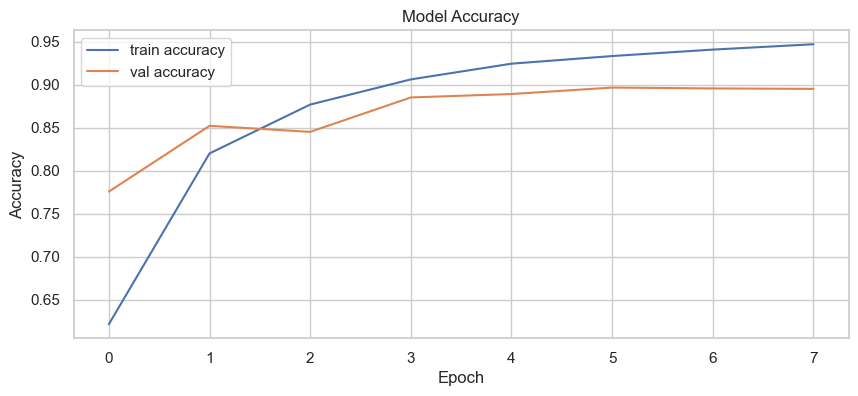

In [33]:
# Visualization model accuracy (train and val accuracy)

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(model_prediction.history['accuracy'], label = 'train accuracy')
ax.plot(model_prediction.history['val_accuracy'], label = 'val accuracy')
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc = 'upper left')
plt.show()

157/157 [==============================] - 2s 8ms/step
Accuracy on Test Data: 0.8966
F1-Score: [0.93099415 0.78011472 0.8985156 ]


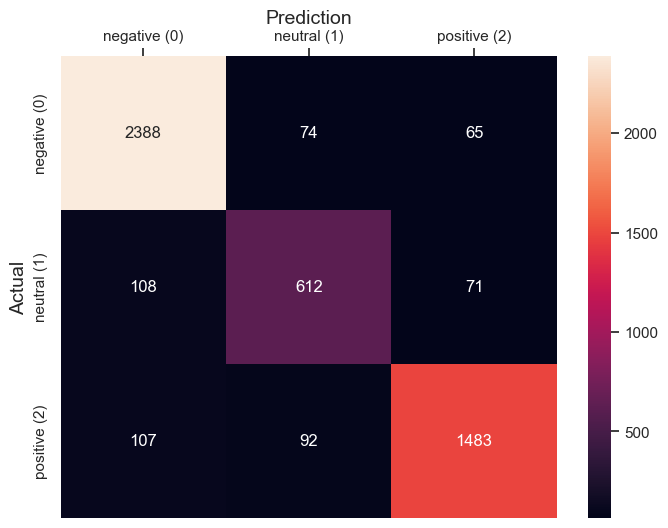

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2527
           1       0.79      0.77      0.78       791
           2       0.92      0.88      0.90      1682

    accuracy                           0.90      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.90      0.90      0.90      5000



In [34]:
# Predict sentiment on data test by using model has been created, and then visualize a confusion matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on Test Data:', accuracy)
confusion_matrix(y_test, y_pred)
print('F1-Score:', f1_score(y_test, y_pred, average=None))

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels(['negative (0)', 'neutral (1)', 'positive (2)'])
plt.show()
print(classification_report(y_test, y_pred))


## Save Model

In [24]:
model.save('model_modifikasi.h5')

## Results from prediction sentiment on data test

In [25]:
text_clean = tweets['text_clean']
text_train, text_test = train_test_split(text_clean, test_size = 0.2, random_state = 0)

result_test = pd.DataFrame({'text': text_test, 
                            'aktual': y_test,
                            'prediction': y_pred})
sentiment_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
result_test['aktual'] = result_test['aktual'].map(sentiment_decode)
result_test['prediction'] = result_test['prediction'].map(sentiment_decode)
pd.set_option('max_colwidth', 300)
result_test

,text,aktual,prediction
14149,setresku nambah gara gara kuliah online,Negative,Negative
8946,adek gue yang kuliah online gue yang capek liatnya ner bener dari pagi ampe malem bahkan minggu pun depan laptop sungguh rawan mata minus,Negative,Negative
22378,yatuhan aku bener gabisa kuliah online gini ra mudeng blass 😭,Positive,Positive
12162,sekarang lagi semeter magang kuliah online tugasnya karya rasanya pengen nikah aja udah tapi belum siap wkwkwk,Positive,Positive
4879,pengen kuliah online ampe lulus,Positive,Positive
...,...,...,...
4022,ngerjain setengah mampus pas diliat feedback dosen dapet nilai dan bilang file ku ga kebaca sumpah ya benci banget sama kuliah online,Positive,Neutral
17601,ternyata kulon kuliah online bisa membuat ip jadi segini 😂 terima kasih kuliah online 😂😂,Positive,Positive
4718,soalnya kalo gak dikasih teh siangnya suka lemes apalagi kalo kuliah online mah mungkin bisa lemes parah bukan lemes aja,Negative,Negative
9376,kuliah online udh memasuki bulan ke kalo di total total kerugian gua hari bln x hari rp anjayaniiiii ternyata kerugian ku bisa beli iphone second,Negative,Negative


## Predict with Other Data

In [26]:
# Initializing and preprocessing new text data
otherData = pd.DataFrame()
otherData['text'] = ['enaknya kuliah online, ga perlu capek" ke kampus dan bisa santai dirumah',
                    'Tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif, ga paham materi blasss, kopong, berasa yauda kek ga kuliah', 
                    'tumbenan td kuliah online dosennya minta join zoom, trs temen ngcht nyuruh masuk krn yg lain udh join, tinggal gua doang yg blm, Okedeh....   cepet cepet,cuma pakek daster + kemeja (ditimpa gt daster gua) + pasmina🙂  Jadilaaaa',
                    'Ya allah hebat kali aing ya dulu gapyear sekarang kuliah online. Berasa nganggur 2 tahun ngab',
                    'Kalo kuliah online berasa sia sia njirr, bayar ukt elit nikmati fasilitas sulit'
                    ]
otherData['text_clean'] = otherData['text'].apply(cleaningText)
otherData['text_clean'] = otherData['text_clean'].apply(casefoldingText)
otherData.drop(['text'], axis = 1, inplace = True)

otherData['text_preprocessed'] = otherData['text_clean'].apply(tokenizingText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(filteringText)
otherData['text_preprocessed'] = otherData['text_preprocessed'].apply(stemmingText)
otherData

,text_clean,text_preprocessed
0,enaknya kuliah online ga perlu capek ke kampus dan bisa santai dirumah,"[enak, kuliah, online, ga, capek, kampus, santai, rumah]"
1,tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif ga paham materi blasss kopong berasa yauda kek ga kuliah,"[serius, deh, kesini, ngerasa, kuliah, online, ga, efektif, ga, paham, materi, blasss, kopong, asa, yauda, kek, ga, kuliah]"
2,tumbenan td kuliah online dosennya minta join zoom trs temen ngcht nyuruh masuk krn yg lain udh join tinggal gua doang yg blm okedeh cepet cepetcuma pakek daster kemeja ditimpa gt daster gua pasmina🙂 jadilaaaa,"[tumben, td, kuliah, online, dosen, join, zoom, trs, temen, ngcht, nyuruh, masuk, krn, yg, udh, join, tinggal, gua, doang, yg, blm, okedeh, cepet, cepetcuma, pakek, daster, kemeja, timpa, gt, daster, gua, pasmina, jadilaaaa]"
3,ya allah hebat kali aing ya dulu gapyear sekarang kuliah online berasa nganggur tahun ngab,"[ya, allah, hebat, kali, aing, ya, gapyear, kuliah, online, asa, nganggur, ngab]"
4,kalo kuliah online berasa sia sia njirr bayar ukt elit nikmati fasilitas sulit,"[kalo, kuliah, online, asa, sia, sia, njirr, bayar, ukt, elit, nikmat, fasilitas, sulit]"


In [27]:
# Preprocessing text data
# Make text preprocessed (tokenized) to untokenized with toSentence Function
#Load model
model = load_model('model_modifikasi.h5')
X_otherData = otherData['text_preprocessed'].apply(toSentence)
X_otherData = tokenizer.texts_to_sequences(X_otherData.values)
X_otherData = pad_sequences(X_otherData, maxlen = X.shape[1])

In [28]:
# Results from prediction sentiment on text data
y_pred_otherData = model.predict(X_otherData)
y_pred_otherData = np.argmax(y_pred_otherData, axis=1)
otherData['Result Prediction'] = y_pred_otherData

sentiment_decode = {0 : 'Negative', 1 : 'Neutral', 2 : 'Positive'}
otherData['Result Prediction'] = otherData['Result Prediction'].map(sentiment_decode)
otherData

1/1 [==============================] - 0s 427ms/step


,text_clean,text_preprocessed,Result Prediction
0,enaknya kuliah online ga perlu capek ke kampus dan bisa santai dirumah,"[enak, kuliah, online, ga, capek, kampus, santai, rumah]",Positive
1,tapi serius deh semakin kesini ngerasa kuliah online makin ga efektif ga paham materi blasss kopong berasa yauda kek ga kuliah,"[serius, deh, kesini, ngerasa, kuliah, online, ga, efektif, ga, paham, materi, blasss, kopong, asa, yauda, kek, ga, kuliah]",Negative
2,tumbenan td kuliah online dosennya minta join zoom trs temen ngcht nyuruh masuk krn yg lain udh join tinggal gua doang yg blm okedeh cepet cepetcuma pakek daster kemeja ditimpa gt daster gua pasmina🙂 jadilaaaa,"[tumben, td, kuliah, online, dosen, join, zoom, trs, temen, ngcht, nyuruh, masuk, krn, yg, udh, join, tinggal, gua, doang, yg, blm, okedeh, cepet, cepetcuma, pakek, daster, kemeja, timpa, gt, daster, gua, pasmina, jadilaaaa]",Negative
3,ya allah hebat kali aing ya dulu gapyear sekarang kuliah online berasa nganggur tahun ngab,"[ya, allah, hebat, kali, aing, ya, gapyear, kuliah, online, asa, nganggur, ngab]",Positive
4,kalo kuliah online berasa sia sia njirr bayar ukt elit nikmati fasilitas sulit,"[kalo, kuliah, online, asa, sia, sia, njirr, bayar, ukt, elit, nikmat, fasilitas, sulit]",Negative


In [29]:
## predict

input_text = 'pengen kuliah online ampe lulus'
text = [input_text]
new_text = []
for text in text:
    preprocessed_text = toSentence(stemmingText(filteringText(tokenizingText
                        (casefoldingText(cleaningText(text))))))
    new_text.append(preprocessed_text)
print(new_text)
text_seq = tokenizer.texts_to_sequences(new_text)
text_seq = pad_sequences(text_seq, maxlen = 47)
text_pred = model.predict(text_seq)
text_pred = np.argmax(text_pred, axis=1)
print(X.shape)
if text_pred == 0:
    text_result = 'Negatif'
elif text_pred == 1:
    text_result = 'Neutral'
else:
    text_result ='Positive'
print('Hasil prediksi sentiment = ', text_result)

['ken kuliah online ampe lulus']
1/1 [==============================] - 0s 27ms/step
(25000, 47)
Hasil prediksi sentiment =  Positive
